## Model

In [165]:
## For Model
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from fredapi import Fred
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import math

## For Dashboard
import dash
import dash_core_components as dcc
import dash_html_components as html




[*********************100%***********************]  2 of 2 completed


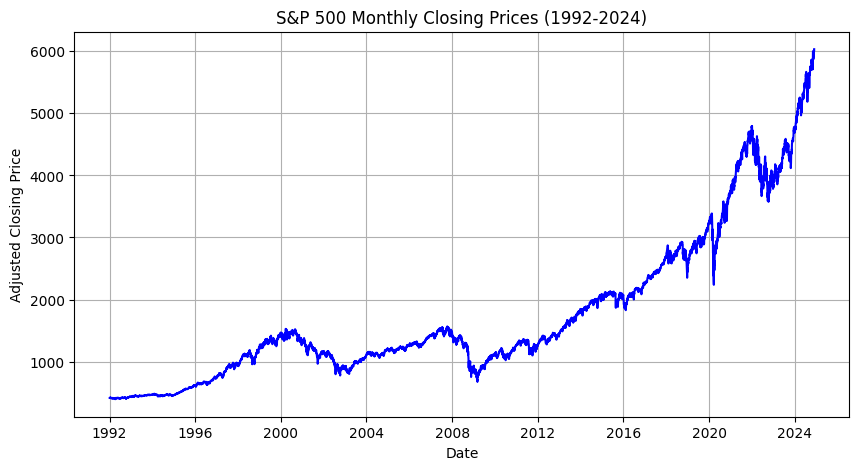

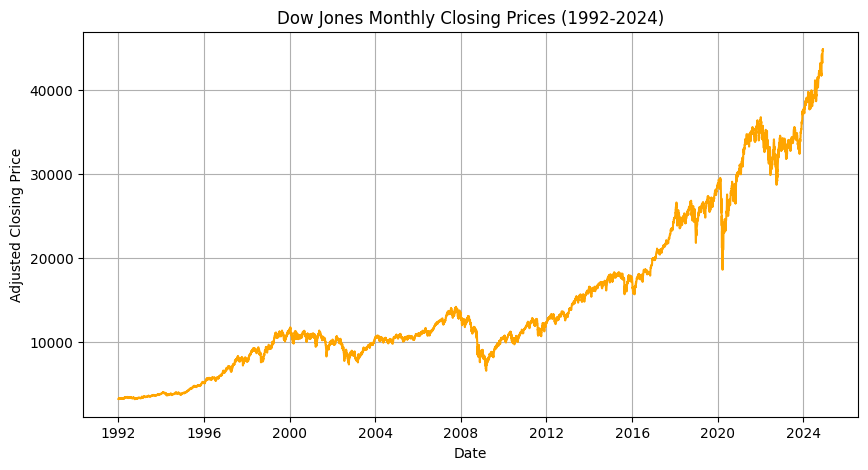

In [158]:
# S&P 500 and Dow Jones data from Yahoo Finance
# Stock Market Data

start_date = '1992-01-02'

tickers = ["^GSPC", "^DJI"]
stock_market_data = yf.download(
    tickers, start=start_date, end="2024-12-31", interval="1d"
)

sp500_data = stock_market_data["Adj Close"]["^GSPC"]

dowjones_data = stock_market_data["Adj Close"]["^DJI"]

dowjones_data = dowjones_data.dropna()


# Plot for S&P 500
plt.figure(figsize=(10, 5))
plt.plot(sp500_data.index, sp500_data, color="blue")
plt.title("S&P 500 Monthly Closing Prices (1992-2024)")
plt.xlabel("Date")
plt.ylabel("Adjusted Closing Price")
plt.grid()
plt.show()

# Plot for Dow Jones
plt.figure(figsize=(10, 5))
plt.plot(dowjones_data.index, dowjones_data, color="orange")
plt.title("Dow Jones Monthly Closing Prices (1992-2024)")
plt.xlabel("Date")
plt.ylabel("Adjusted Closing Price")
plt.grid()
plt.show()


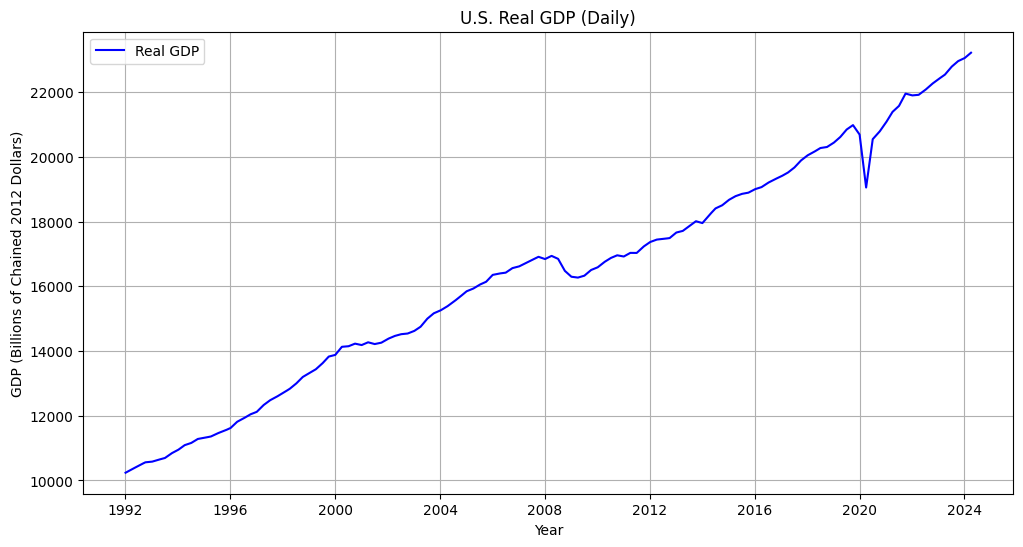

'\n1947-01-01  2182.681\n1947-04-01  2176.892\n'

In [141]:
# GDP data from FRED
gdp_data = pd.read_csv("gdp_data_1965_2024.csv")
gdp_data.rename(columns={
    "Unnamed: 0": "date"
}, inplace=True)
gdp_data['date'] = pd.to_datetime(gdp_data['date'])

gdp_data.set_index("date", inplace=True)

daily_index = pd.date_range(start=gdp_data.index.min(), end=gdp_data.index.max(), freq='D')

gdp_data_daily = gdp_data.reindex(daily_index)

gdp_data_daily['Real GDP'] = gdp_data_daily['Real GDP'].interpolate(method='linear')

gdp_data_daily = gdp_data_daily.loc[start_date:]

# Plot for GDP
plt.figure(figsize=(12, 6))
plt.plot(
    gdp_data_daily.index,
    gdp_data_daily["Real GDP"],
    color="blue",
    label="Real GDP",
)
plt.title("U.S. Real GDP (Daily)")
plt.xlabel("Year")
plt.ylabel("GDP (Billions of Chained 2012 Dollars)")
plt.grid()
plt.legend()
plt.show()

"""
1947-01-01  2182.681
1947-04-01  2176.892
"""


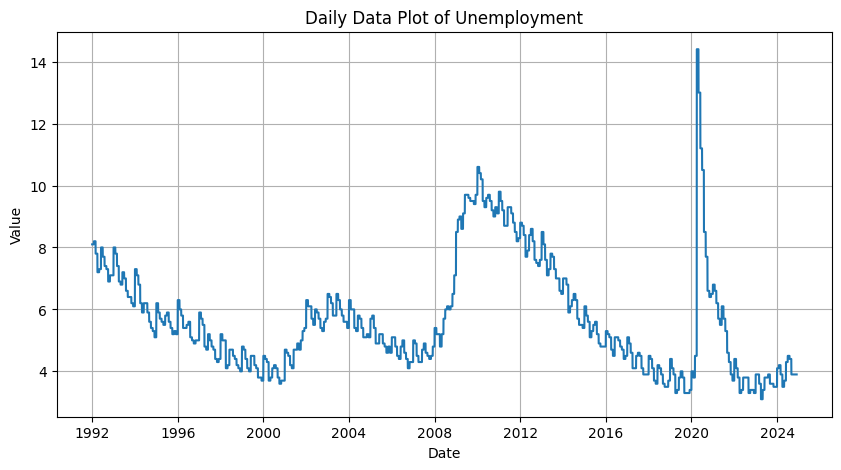

In [142]:
# Unemployment Data
unemployment_data = pd.read_csv("unemployment_data.csv")

unemployment_data_long = unemployment_data.melt(
    id_vars=["Year"], var_name="Month", value_name="Value"
)

unemployment_data_long["Month"] = pd.to_datetime(
    unemployment_data_long["Month"], format="%b"
).dt.month

unemployment_data_long["Date"] = pd.to_datetime(
    unemployment_data_long[["Year", "Month"]].assign(Day=1)
)

unemployment_data_long = unemployment_data_long.sort_values("Date")

unemployment_data_long.set_index("Date", inplace=True)

daily_index = pd.date_range(
    start=unemployment_data_long.index.min(), 
    end=unemployment_data_long.index.max(), 
    freq='D')

unemployment_data_daily = unemployment_data_long.reindex(daily_index)

unemployment_data_daily = unemployment_data_daily.fillna(method="ffill")

unemployment_data_daily = unemployment_data_daily.loc[start_date:]

unemployment_data_daily.index.name = 'Date'

# Plot for unemployment rate
plt.figure(figsize=(10, 5))
plt.plot(unemployment_data_daily.index, unemployment_data_daily["Value"])
plt.title("Daily Data Plot of Unemployment")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid()
plt.show()

              Year  Month       CPI
Date                               
1992-01-02  1992.0    1.0  3.896774
1992-01-03  1992.0    1.0  3.893548
1992-01-04  1992.0    1.0  3.890323
1992-01-05  1992.0    1.0  3.887097
1992-01-06  1992.0    1.0  3.883871
...            ...    ...       ...
2024-11-27  2024.0   11.0  3.300000
2024-11-28  2024.0   11.0  3.300000
2024-11-29  2024.0   11.0  3.300000
2024-11-30  2024.0   11.0  3.300000
2024-12-01  2024.0   12.0  3.300000

[12023 rows x 3 columns]


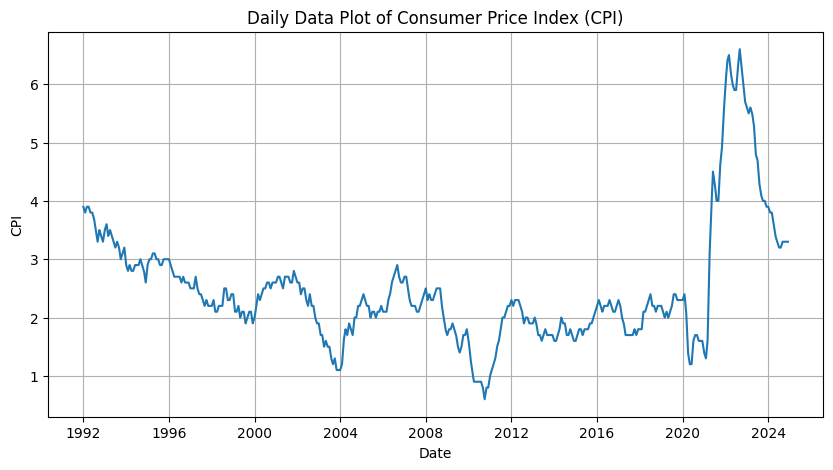

In [143]:
# CPI Data
cpi_data = pd.read_csv("cpi_data.csv")
cpi_data.drop(columns=["HALF1", "HALF2"], inplace=True)
cpi_data_long = cpi_data.melt(id_vars=["Year"], var_name="Month", value_name="CPI")
cpi_data_long["Month"] = pd.to_datetime(cpi_data_long["Month"], format="%b").dt.month
cpi_data_long["Date"] = pd.to_datetime(cpi_data_long[["Year", "Month"]].assign(Day=1))
cpi_data_long = cpi_data_long.sort_values("Date")

daily_index = pd.date_range(start=cpi_data_long['Date'].min(), 
                            end=cpi_data_long['Date'].max(), 
                            freq='D')

cpi_data_daily = cpi_data_long.set_index('Date').reindex(daily_index)

cpi_data_daily['CPI'] = cpi_data_daily['CPI'].interpolate(method='linear')
cpi_data_daily['Year'] = cpi_data_daily['Year'].fillna(method="ffill")
cpi_data_daily['Month'] = cpi_data_daily['Month'].fillna(method="ffill")

cpi_data_daily.index.name = 'Date'

cpi_data_daily = cpi_data_daily.loc[start_date:]
print(cpi_data_daily)

#loc[start_date:]

# Plot for CPI
plt.figure(figsize=(10, 5))
plt.plot(cpi_data_daily.index, cpi_data_daily["CPI"])
plt.title("Daily Data Plot of Consumer Price Index (CPI)")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.grid()
plt.show()

            Federal Funds Rate  10-Year Treasury Rate
Date                                                 
1992-01-02                4.81                   7.48
1992-01-03                4.81                   7.48
1992-01-04                4.81                   7.48
1992-01-05                4.81                   7.48
1992-01-06                4.81                   7.48
...                        ...                    ...
2024-07-28                5.33                   4.48
2024-07-29                5.33                   4.48
2024-07-30                5.33                   4.48
2024-07-31                5.33                   4.48
2024-08-01                5.33                   3.99

[11901 rows x 2 columns]


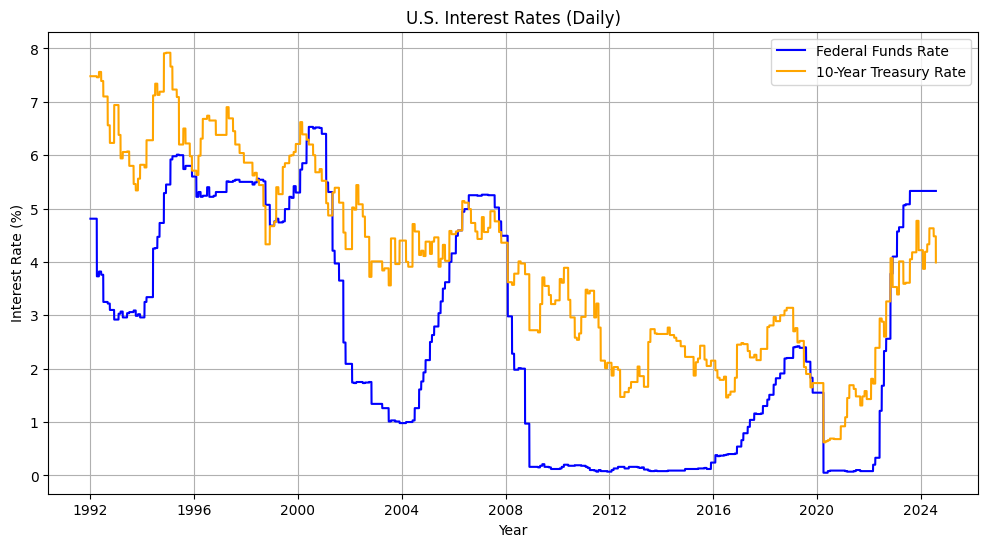

In [144]:
# Interest Rates Data
interest_rates_df = pd.read_csv(
    "interest_rates_1965_2024.csv", index_col=0, parse_dates=True
)

interest_rates_df = interest_rates_df.dropna()

daily_index = pd.date_range(start=interest_rates_df.index.min(), 
                            end=interest_rates_df.index.max(), 
                            freq='D')

interest_rates_daily = interest_rates_df.reindex(daily_index)

interest_rates_daily = interest_rates_daily.fillna(method='ffill')

interest_rates_daily.index.name = 'Date'

interest_rates_daily = interest_rates_daily.loc[start_date:]

print(interest_rates_daily)

# Plot for Interest Rates
plt.figure(figsize=(12, 6))
plt.plot(
    interest_rates_daily.index,
    interest_rates_daily["Federal Funds Rate"],
    label="Federal Funds Rate",
    color="blue",
)
plt.plot(
    interest_rates_daily.index,
    interest_rates_daily["10-Year Treasury Rate"],
    label="10-Year Treasury Rate",
    color="orange",
)
plt.title("U.S. Interest Rates (Daily)")
plt.xlabel("Year")
plt.ylabel("Interest Rate (%)")
plt.legend()
plt.grid()
plt.show()

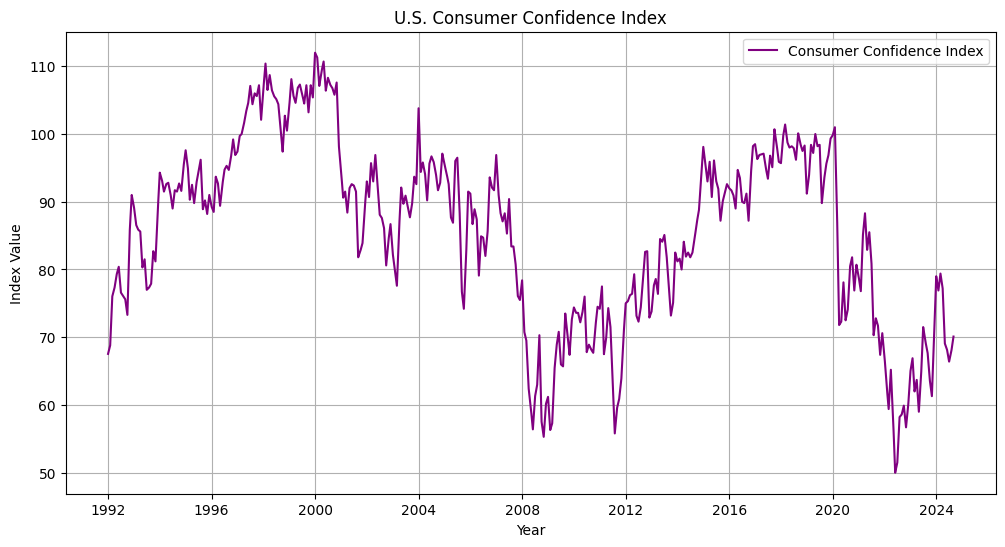

In [145]:
# Consumer Confidence Index Data
consumer_confidence_df = pd.read_csv(
    "consumer_confidence_index_1965_2024.csv", index_col=0, parse_dates=True
)

consumer_confidence_df = consumer_confidence_df.interpolate(method="linear")

daily_index = pd.date_range(start=consumer_confidence_df.index.min(), 
                            end=consumer_confidence_df.index.max(), 
                            freq='D')

consumer_confidence_daily = consumer_confidence_df.reindex(daily_index)

consumer_confidence_daily = consumer_confidence_daily.interpolate(method="linear")

consumer_confidence_daily.index.name = 'Date'

consumer_confidence_daily = consumer_confidence_daily.loc[start_date:]

# print(consumer_confidence_daily)

# Plot for Consumer Confidence Index
plt.figure(figsize=(12, 6))
plt.plot(
    consumer_confidence_daily.index,
    consumer_confidence_daily["Consumer Confidence Index"],
    color="purple",
    label="Consumer Confidence Index",
)
plt.title("U.S. Consumer Confidence Index")
plt.xlabel("Year")
plt.ylabel("Index Value")
plt.grid()
plt.legend()
plt.show()

In [ ]:
sp500_data.index = sp500_data.index.tz_localize(None)
dowjones_data.index = dowjones_data.index.tz_localize(None)

sp500_data_diff = sp500_data.pct_change().dropna()
dowjones_data_diff = dowjones_data.pct_change().dropna()

combined_exogenous_data = pd.DataFrame({
    'GDP': gdp_data_daily['Real GDP'],
    'Unemployment Rate': unemployment_data_daily['Value'],
    'CPI': cpi_data_daily['CPI'],
    'Interest Rates': interest_rates_daily['Federal Funds Rate'],
    'Consumer Confidence Index': consumer_confidence_daily['Consumer Confidence Index']
})

combined_exogenous_data = combined_exogenous_data.fillna(method='ffill')

In [199]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

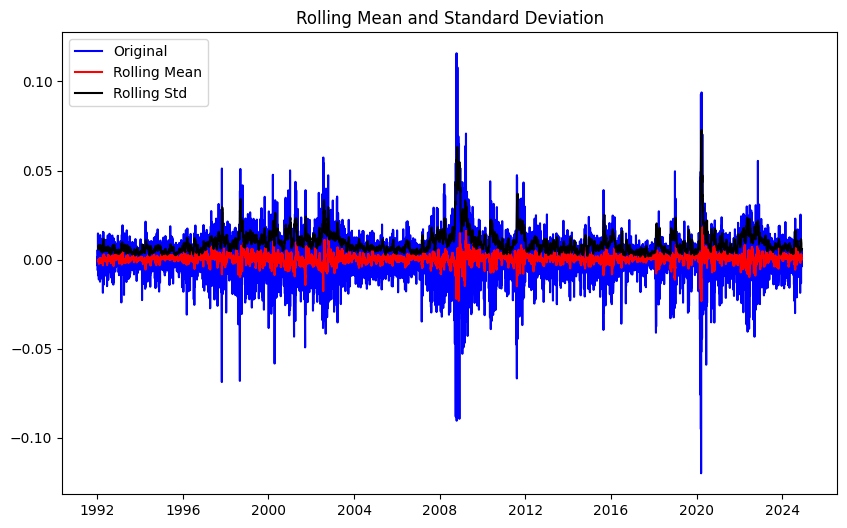

Results of dickey fuller test
Test Statistics               -1.706210e+01
p-value                        7.933229e-30
No. of lags used               3.300000e+01
Number of observations used    8.255000e+03
critical value (1%)           -3.431142e+00
critical value (5%)           -2.861890e+00
critical value (10%)          -2.566956e+00
dtype: float64


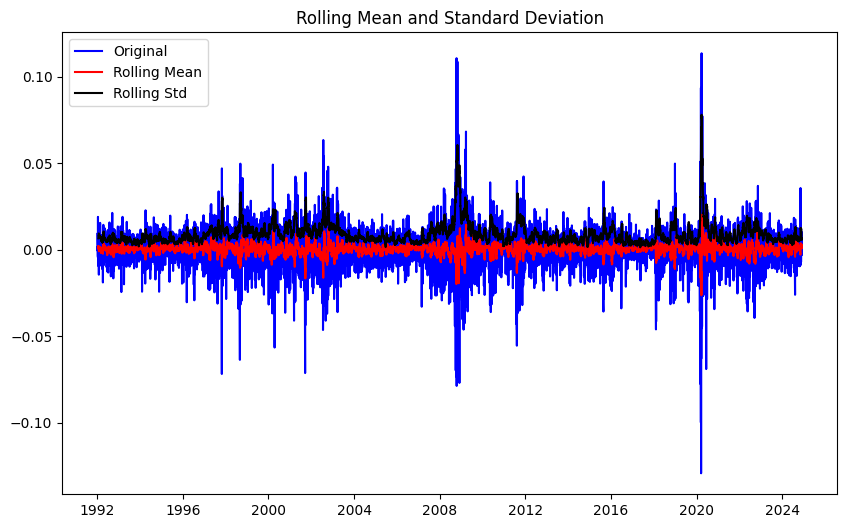

Results of dickey fuller test
Test Statistics               -1.764544e+01
p-value                        3.741649e-30
No. of lags used               3.300000e+01
Number of observations used    8.255000e+03
critical value (1%)           -3.431142e+00
critical value (5%)           -2.861890e+00
critical value (10%)          -2.566956e+00
dtype: float64


In [200]:
test_stationarity(sp500_data_diff)
test_stationarity(dowjones_data_diff)

In [201]:
sp500_data_diff = sp500_data_diff.diff().dropna()
dowjones_data_diff = dowjones_data_diff.diff().dropna()

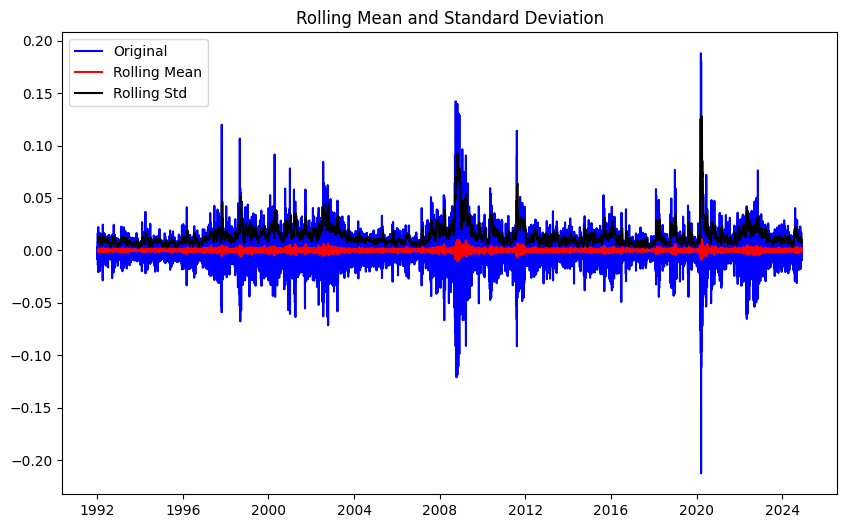

Results of dickey fuller test
Test Statistics                 -25.926657
p-value                           0.000000
No. of lags used                 37.000000
Number of observations used    8250.000000
critical value (1%)              -3.431143
critical value (5%)              -2.861890
critical value (10%)             -2.566957
dtype: float64


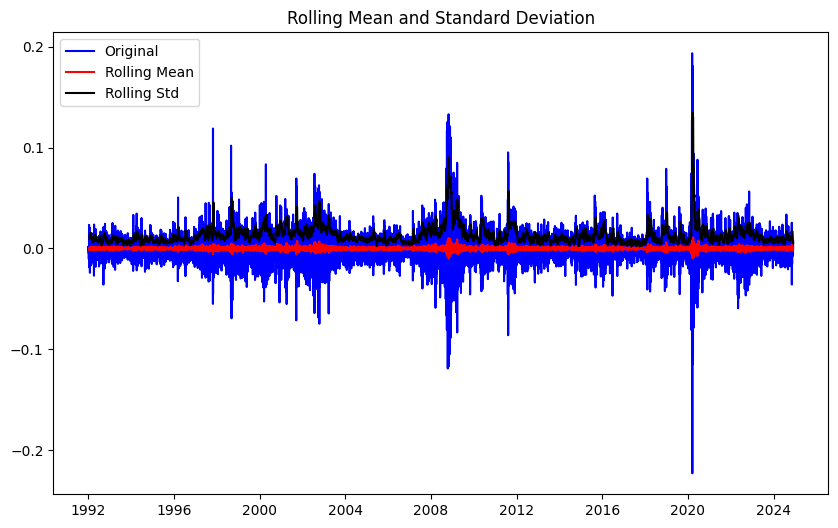

Results of dickey fuller test
Test Statistics                 -25.954030
p-value                           0.000000
No. of lags used                 37.000000
Number of observations used    8250.000000
critical value (1%)              -3.431143
critical value (5%)              -2.861890
critical value (10%)             -2.566957
dtype: float64


In [202]:
test_stationarity(sp500_data_diff)
test_stationarity(dowjones_data_diff)

In [ ]:
combined_exogenous_data_lagged = pd.DataFrame()
for lag in range(1, 4):
    combined_exogenous_data_lagged[f'GDP_Lag{lag}'] = combined_exogenous_data['GDP'].shift(lag)
    combined_exogenous_data_lagged[f'Unemployment_Rate_Lag{lag}'] = combined_exogenous_data['Unemployment Rate'].shift(lag)
    combined_exogenous_data_lagged[f'CPI_Lag{lag}'] = combined_exogenous_data['CPI'].shift(lag)
    combined_exogenous_data_lagged[f'Interest_Rates_Lag{lag}'] = combined_exogenous_data['Interest Rates'].shift(lag)
    combined_exogenous_data_lagged[f'Consumer_Confidence_Index_Lag{lag}'] = combined_exogenous_data['Consumer Confidence Index'].shift(lag)
    
combined_exogenous_data_lagged 


,GDP_Lag1,Unemployment_Rate_Lag1,CPI_Lag1,Interest_Rates_Lag1,Consumer_Confidence_Index_Lag1,GDP_Lag2,Unemployment_Rate_Lag2,CPI_Lag2,Interest_Rates_Lag2,Consumer_Confidence_Index_Lag2,GDP_Lag3,Unemployment_Rate_Lag3,CPI_Lag3,Interest_Rates_Lag3,Consumer_Confidence_Index_Lag3
1992-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-01-03,10237.654714,8.1,3.896774,4.81,67.541935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-01-04,10238.874429,8.1,3.893548,4.81,67.583871,10237.654714,8.1,3.896774,4.81,67.541935,NaN,NaN,NaN,NaN,NaN
1992-01-05,10240.094143,8.1,3.890323,4.81,67.625806,10238.874429,8.1,3.893548,4.81,67.583871,10237.654714,8.1,3.896774,4.81,67.541935
1992-01-06,10241.313857,8.1,3.887097,4.81,67.667742,10240.094143,8.1,3.890323,4.81,67.625806,10238.874429,8.1,3.893548,4.81,67.583871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-27,23223.906000,3.9,3.300000,5.33,70.100000,23223.906000,3.9,3.300000,5.33,70.100000,23223.906000,3.9,3.300000,5.33,70.100000
2024-11-28,23223.906000,3.9,3.300000,5.33,70.100000,23223.906000,3.9,3.300000,5.33,70.100000,23223.906000,3.9,3.300000,5.33,70.100000
2024-11-29,23223.906000,3.9,3.300000,5.33,70.100000,23223.906000,3.9,3.300000,5.33,70.100000,23223.906000,3.9,3.300000,5.33,70.100000
2024-11-30,23223.906000,3.9,3.300000,5.33,70.100000,23223.906000,3.9,3.300000,5.33,70.100000,23223.906000,3.9,3.300000,5.33,70.100000


In [203]:
scaler = StandardScaler()
combined_exogenous_data_scaled = scaler.fit_transform(combined_exogenous_data)
combined_exogenous_data_scaled = pd.DataFrame(
    combined_exogenous_data_scaled, 
    columns=combined_exogenous_data.columns, 
    index=combined_exogenous_data.index
)


In [204]:
sp500_combined = pd.concat([sp500_data_diff, combined_exogenous_data_scaled], axis=1).dropna()
dowjones_combined = pd.concat([dowjones_data_diff, combined_exogenous_data_scaled], axis=1).dropna()


In [224]:
train_size = int(len(sp500_combined) * 0.8)
sp500_train = sp500_combined.iloc[:train_size]
sp500_test = sp500_combined.iloc[train_size:]

dow_train = dowjones_combined.iloc[:train_size]
dow_test = dowjones_combined.iloc[train_size:]


In [228]:
auto_model_sp500 = auto_arima(
    sp500_train['^GSPC'], 
    exogenous=sp500_train.drop('^GSPC', axis=1), 
    seasonal=False, 
    trace=True
)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=2.38 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-35744.476, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-37711.898, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.73 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-38697.515, Time=0.34 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-39156.499, Time=0.73 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-39370.734, Time=0.97 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-39605.297, Time=1.00 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=-40476.589, Time=3.19 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=2.57 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=-40570.625, Time=4.08 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-40684.936, Time=3.17 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=4.35 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=-40679.269, Time=3.46 sec
 ARIMA(3,0,1)(0,0,0)[0]          

In [233]:

sarimax_model_sp500 = SARIMAX(
    sp500_train['^GSPC'], 
    exog=sp500_train.drop('^GSPC', axis=1), 
    order=(4,0,2)
)
results_sp500 = sarimax_model_sp500.fit()


In [ ]:
forecast_sp500 = results_sp500.predict(
    start=len(sp500_train), 
    end=len(sp500_train) + len(sp500_test) - 1, 
    exog=sp500_test.drop('^GSPC', axis=1)
)


In [255]:
# Calculate RMSE for S&P 500
rmse_sp500 = np.sqrt(mean_squared_error(sp500_test['^GSPC'], forecast_sp500))
print(f'S&P 500 RMSE: {rmse_sp500}')


S&P 500 RMSE: 0.019045518833881857


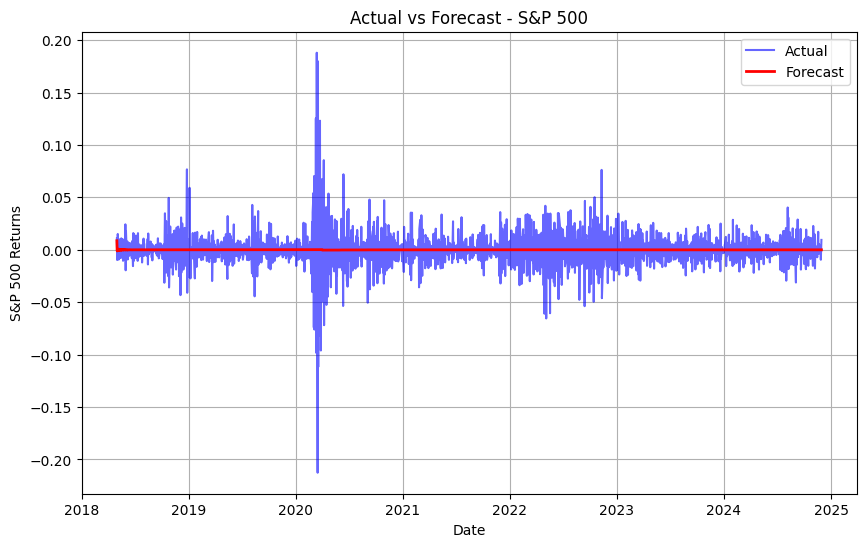

In [260]:
plt.figure(figsize=(10, 6))
plt.plot(sp500_test.index, sp500_test['^GSPC'], label='Actual', color='blue', alpha=0.6)
plt.plot(sp500_test.index, forecast_sp500, label='Forecast', color='red', linewidth=2)
plt.title('Actual vs Forecast - S&P 500')
plt.xlabel('Date')
plt.ylabel('S&P 500 Returns')
plt.legend()
plt.grid()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (1658,) and (3316,)

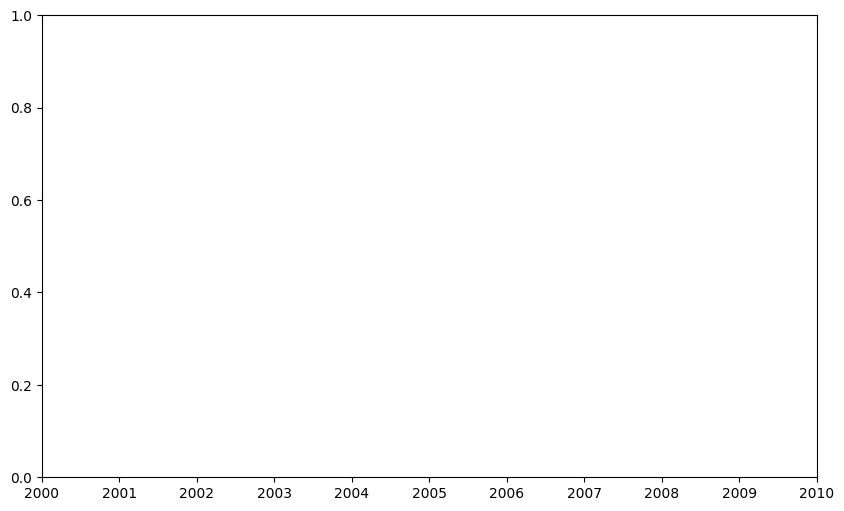

In [259]:
residuals = sp500_test['^GSPC'] - forecast_sp500
plt.figure(figsize=(10, 6))
plt.plot(sp500_test.index, residuals, label='Residuals', color='green')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residuals - S&P 500')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Forecast the next 30 days
future_exog = pd.DataFrame({
    'GDP_Lag1': [5.5, 5.6, 5.7],  # Replace with realistic values
    'Unemployment_Lag1': [4.0, 4.1, 4.2],
    # Add more lagged variables
})


NameError: name 'results_sp500' is not defined

## Dash Code

In [ ]:
## Dash Code

app = dash.Dash()

app.layout = html.Div([
    html.H1("Hello Dash!!!"),
    html.Div("Dash - A Data Product")
])

if __name__ == '__main__':
    app.run_server(port=4050)